# Mixed layer heat budget analysis of ACCESS-OM2 runs

This notebook contains a quick analysis of the mixed layer heat budget in ACCESS-OM2, using online heat budget diagnostics.

## Background Theory and diagnostics

### ACCESS-OM2 "Eulerian" heat budget


\begin{align}
  \textit{temp\_tendency} = &\textit{temp\_advection} + \\ &\quad +
  \textit{temp\_submeso} \\ &\quad + \textit{temp\_vdiffuse\_diff\_cbt}  + \textit{temp\_nonlocal\_KPP} \\ &\quad + \textit{sw\_heat} +
  \textit{temp\_rivermix} + \textit{temp\_vdiffuse\_sbc} + \textit{sfc\_hflux\_pme} \\
  & \quad + \textit{frazil\_3d}\\ 
   & \quad + \textit{temp\_vdiffuse\_k33} + \textit{neutral\_diffusion\_temp}\\
   & \quad + \textit{neutral\_gm\_temp} \\
   & \quad + \textit{mixdownslope\_temp} + \textit{temp\_sigma\_diff} + \textit{temp\_eta\_smooth}
\end{align}

All terms are in units of Wm$^{-2}$ - i.e. the tendency of the heat content within each grid cell per unit area, $\rho_0 C_p\Theta \Delta z$, where $\Delta z$ is the time variable grid cell thickness, $\rho_0=1035$kgm$^{-3}$ is the reference density, $C_p=3992.10322329649$Jkg$^{-1}$$^\circ$C$^{-1}$ is the specific heat and $\Theta$ is Conservative Temperature.

- temp\_tendency is the tendency term
- temp\_advection is the convergence of the three-dimensional resolved advection (this can be split into components by taking the convergence of the temp\_xflux\_adv, temp\_yflux\_adv and temp\_zflux\_adv terms)
- temp\_submeso is the convergence of the three-dimensional parameterized submesoscale advection (pretty small).
- temp\_vdiffuse\_diff\_cbt and temp\_nonlocal\_KPP are the vertical mixing terms.
- The next line contains all of the surface heat flux terms. Note that sw\_heat is a three-dimensional term that *redistributes* the impact of SW radiation from the surface layer into the interior (i.e. it is negative in the surface layer and positive below, summing to zero). temp\_rivermix is also three-dimensional as the impact of river runoff is spread over a few layers (4 I think). The other terms are two-dimensional (only non-zero in the surface layer).
- frazil\_3d is the formation of frazil ice
- temp\_vdiffuse\_k33 and neutral\_diffusion\_temp are parameterized along-isopycnal mixing (might not be on in all configurations, e.g. ACCESS-OM2-01).
- neutral\_gm\_temp is parameterization advection by mesoscale eddies
- The last line includes some miscellaneous mixing terms (all pretty small).

Also see https://github.com/COSIMA/access-om2/issues/139#issuecomment-639278547 for a discussion of the surface heat flux terms in ACCESS-OM2/CM2.

### Mixed layer temperature budget 

At each grid cell write the model heat budget above as

$$\frac{\partial (\rho_0 C_p \Theta \Delta z)}{\partial t} = \textit{temp\_tendency} = \sum_i P_i$$

Where $P_i$ are the RHS processes. Units are Wm$^{-2}$. Summing (where we use an integral sign for simplicity) over a mixed layer of depth $MLD(x,y,t)$ gives

$$\int_{-MLD}^\eta \frac{\partial (\rho_0 C_p \Theta \Delta z)}{\partial t} = \int_{-MLD}^\eta \sum_i P_i$$

Using a Leibniz rule for the LHS gives

$$\frac{\partial}{\partial t} \int_{-MLD}^\eta (\rho_0 C_p \Theta \Delta z) - \frac{\partial MLD}{\partial t}\rho_0 C_p \Theta_{ent} = \int_{-MLD}^\eta \sum_i P_i$$

Where $\Theta_{ent}=\Theta(x,y,z=MLD,t)$ is the temperature at the base of the mixed layer. Setting $\int_{-MLD}^\eta (\rho_0 C_p \Theta \Delta z) = \rho_0 C_p \Theta_{MLD} MLD$, where $\Theta_{MLD}$ is the mixed layer average temperature. We thus have:
\begin{align*}
    \frac{\partial (\rho_0 C_p \Theta_{MLD} MLD)}{\partial t} - \frac{\partial MLD}{\partial t}\rho_0 C_p \Theta_{ent} &= \int_{-MLD}^\eta \sum_i P_i \\
    \Longrightarrow \frac{\partial \Theta_{MLD}}{\partial t} + \frac{1}{MLD}\frac{\partial MLD}{\partial t}\left(\Theta_{MLD} - \Theta_{ent}\right) &= \frac{1}{\rho_0 C_p MLD}\int_{-MLD}^\eta \sum_i P_i
\end{align*}

This forms a budget for the tendency of the temperature averaged over the mixed layer (effectively, the SST), where the first term on the LHS is the mixed layer temperature tendency, the second term is the entrainment term and the RHS terms are as before. 

This calculation shows that the entrainment term is not an explicit diagnostic in ACCESS-OM2. However, the above equation suggests a method to compute it. I.e. one could compute a closed budget by computing the mixed layer temperature tendency offline (for full accuracy this should be done with *snapshots* of the temperature rather than time averages) and then computing the entrainment term as a residual from the integral of temp\_tendency over the mixed layer (the LHS of the above equation, divided by MLD). I.e.

$$\frac{1}{MLD}\frac{\partial MLD}{\partial t}\left(\Theta_{MLD} - \Theta_{ent}\right) =  - \frac{\partial \Theta_{MLD}}{\partial t} + \frac{1}{\rho_0 C_p MLD} \int_{-MLD}^\eta temp\_tendency$$


Of course, while it is a closed budget, it's not exactly a budget of the mixed layer temperature because of the averaging time-scale of the diagnostics (e.g. with daily average diagnostics, the terms don't account for subdaily correlations). But it shouldn't be far off. The computations below test this assumption by comparing daily and monthly averaged diagnostics (although the saving of daily averaged diagnostics over a long simulation is rather impractical).

I believe that it is easier to work with the mixed layer temperature budget (as written above), rather than a mixed layer heat content budget, because it is easier to avoid errors associated with mismatches between budget terms and MLD/grid-cell thicknesses. The mixed layer temperature varies much more smoothly with time than the mixed layer heat content (i.e. as the mixed layer depth varies).

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cftime
from datetime import datetime

import cmocean as cm
import sys, os

from dask.distributed import Client
client = Client(processes=False)

In [2]:
# Load workers:
client = Client(n_workers=16)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44253 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44253/status,
Dashboard: /proxy/44253/status,Workers: 16
Total threads: 32,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37427,Workers: 16
Dashboard: /proxy/44253/status,Total threads: 32
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:32823,Total threads: 2
Dashboard: /proxy/44087/status,Memory: 15.70 GiB
Nanny: tcp://127.0.0.1:46499,


In [3]:
# Chdir for figure saving:
# os.chdir('access-om2-analysis/access-om2-sst-budget')

In [4]:
%%time
# daily data:
ds_budget_daily = xr.open_dataset(base2 + 'ocean_budget_daily.nc').sel(xt_ocean=slice(reg[0],reg[1]),yt_ocean=slice(reg[2],reg[3]))
ds_daily = xr.open_dataset(base2 + 'ocean_daily.nc').sel(xt_ocean=slice(reg[0],reg[1]),yt_ocean=slice(reg[2],reg[3]))

# Add snapshot from previous output:
ds_snapshot_daily = xr.open_dataset(base2 + 'ocean_snapshot_daily.nc').sel(xt_ocean=slice(reg[0],reg[1]),yt_ocean=slice(reg[2],reg[3]))
ds_snapshot_daily_m1 = xr.open_dataset(base2.replace(str(output),str(output-1)) + 'ocean_snapshot_daily.nc').sel(xt_ocean=slice(reg[0],reg[1]),yt_ocean=slice(reg[2],reg[3]))
ds_snapshot_daily = xr.concat([ds_snapshot_daily_m1.isel(time=-1),ds_snapshot_daily],dim='time')

# NOTE: THere is some bug with the time variable in the daily data - it is offset by a few days. 
# Doesn't make a difference for the below calculations (since I'm averaging over all four months).
# However, important to be aware of.

NameError: name 'base2' is not defined

## Define function to compute mixed layer temperature budget

In [5]:
def compute_mixed_layer_temperature_budget(ds_budget,pot_rho_0,dzt):#,ds_snapshot):
    """
    Compute mixed layer temperature budget

    Inputs:
    ds_budget -> dataset containing time-averaged budget quantities
    pot_rho_0 -> dataarray containing time-averaged surface referenced potential density for MLD calculation
    dzt       -> dataarray containing time-averaged grid-cell thicknesses for MLD calculation
    # ds_snapshot -> dataset containing snapshots of temperature, dzt and pot_rho_0 for mixed layer temperature tendency computation

    Outputs:
    budget -> dataset containing all the terms in the diagnosed mixed layer temperature budget
    """
    rho0 = 1035.
    Cp = 3992.10322329649

    bud_vars = ['temp_tendency','temp_advection','temp_submeso','temp_vdiffuse_diff_cbt','temp_nonlocal_KPP',
            'temp_vdiffuse_sbc','frazil_3d','neutral_diffusion_temp','neutral_gm_temp',
            'temp_vdiffuse_k33','neutral_diffusion_temp','neutral_gm_temp','sw_heat','temp_rivermix']
    budget = ds_budget[bud_vars]

    # Sum over mixed layer:
    mld = dzt.where(pot_rho_0 - pot_rho_0.isel(st_ocean=0) < 0.125).sum('st_ocean') # mixed layer depth
    budget = budget.where(pot_rho_0 - pot_rho_0.isel(st_ocean=0) < 0.125).sum('st_ocean') # Budget summed over mixed layer
    budget = budget/rho0/Cp/mld                                                     # Convert units to degC s-1
    
    # ########################################################################################### #    
    # next, the sw_heat flux across the MLD using the same equation as Zhi                        #
    # formula from Paulson and Simpson (1977): ﻿Irradiance measurements in the upper ocean         #
    budget['sw_heat_cross'] = budget['temp_tendency'].copy()                                      #
    #                                                                                             #
    # the vertical redistribution of SWR, at MLD                                                  #
    R=0.58; h1=0.35; h2=23 # constants                                                            #
    #                                                                                             #
    F_PS77=R * np.exp(-mld / h1) + (1-R) * np.exp(-mld / h2) # exponential decay                  #
    budget['sw_heat_cross']     = budget.sw_heat * F_PS77 # shortwave across the mixed-layer base #
    # ########################################################################################### #    
    
    # Add 2D surface layer variables:
    budget['temp_eta_smooth'] = ds_budget['temp_eta_smooth']/rho0/Cp/mld
    budget['sfc_hflux_pme'] = ds_budget['sfc_hflux_pme']/rho0/Cp/mld
    
    # Compute residual for check:
    budget['residual'] = budget['temp_tendency'].copy()
    for var in budget.data_vars:
        budget['residual'] -= budget[var]

    # Compute mixed layer temperature tendency and entrainment term

    # mixed layer temperature from snapshots:
    mld_month = ds_month.dht.where(ds_month.pot_rho_0 - ds_month.pot_rho_0.isel(st_ocean=0) < 0.125).sum('st_ocean') # mixed layer depth
    mlt_month = (ds_month.dht*(ds_month.temp-273.15)).where(ds_month.pot_rho_0 - ds_month.pot_rho_0.isel(st_ocean=0) < 0.125).sum('st_ocean')
    mlt_month = mlt_month/mld_month                    # mixed layer temperature (deg C)
    budget['ml_temp'] = mlt_month
    
    # mixed layer temperature tendency:
    budget['mlt_tendency'] = budget['temp_tendency'].copy()
    budget['mlt_tendency'] = budget['mlt_tendency'].where(budget['mlt_tendency'] == 0)
    budget['entrainment'] = budget['temp_tendency'].copy()
    budget['entrainment'] = budget['entrainment'].where(budget['entrainment'] == 0)
    shape = budget.temp_tendency.shape
    
    # add the four components of the net_sfc_heating flux
    budget['swflx'] = ds_month['swflx']/rho0/Cp/mld # convert from W/m2 to °C/month
    budget['lw_heat'] = ds_month['lw_heat']/rho0/Cp/mld
    budget['sens_heat'] = ds_month['sens_heat']/rho0/Cp/mld
    budget['evap_heat'] = ds_month['evap_heat']/rho0/Cp/mld

    # and also the minor terms
    budget['frazil_3d_int_z']        = ds_month['frazil_3d_int_z']/rho0/Cp/mld
    budget['fprec_melt_heat']        = ds_month['fprec_melt_heat']/rho0/Cp/mld
    # budget['calving_melt_heat']      = ds_month['calving_melt_heat']/rho0/Cp/mld            # no variable named calving_melt_heat
    budget['mh_flux']                = ds_month['mh_flux']/rho0/Cp/mld
    budget['liceht']                 = ds_month['liceht']/rho0/Cp/mld
    budget['sfc_hflux_pme']          = ds_month['frazil_3d_int_z']/rho0/Cp/mld
    budget['sfc_hflux_from_runoff']  = ds_month['sfc_hflux_from_runoff']/rho0/Cp/mld
    # budget['sfc_hflux_from_calving'] = ds_month['sfc_hflux_from_calving']/rho0/Cp/mld       # no variable named sfc_hflux_from_calving
    
    budget['sst'] = ds_month['temp']

    # now also adding the mixed layer depth for bar charts in Fig. 4.
    budget['mld'] = mld_month

    # # set all values to zero and then NAN for the mlt_tendency and entrainment variables for now
    # # in the next step, I then add in the data for these two fields
    # budget['mlt_tendency'] = xr.zeros_like(budget['mlt_tendency']).where(budget['mlt_tendency'] != 0)
    # budget['entrainment']  = xr.zeros_like(budget['entrainment']).where(budget['mlt_tendency'] != 0)

    
    # budget['mlt_tendency'].data = mlt_month.isel(time=slice(1,None)).values - mlt_month.isel(time=slice(0,11)).values

    # budget['mlt_tendency'].data = np.transpose(mlt_month.isel(time=slice(0,None)).values - mlt_month.values,(2, 0, 1))
    # budget['mlt_tendency'] = budget['mlt_tendency']/(ds_budget.average_DT / np.timedelta64(1, 's'))

    # Entrainment term by residual:
    # budget['entrainment'] = -(budget['temp_tendency'] - budget['mlt_tendency'])

    return(budget)

## Do computations

In [6]:
%%time
base = ['/g/data/e14/rmh561/access-om2/archive/025deg_era5_iaf_1958cycle1/']

# reg = [-100, 20, 0, 60] # Ryan's North Atlantic region
reg = [-100, 20, 0, 70] # Zhi's North Atlantic region


# monthly data:
for e in range(1): # loop through the main run and the extension
    print(' '); print('calculating '+base[e]); print('-------------------------------------------------------------------------------------------------')
    if e == 0: intervall = [0, 66] # output000 to output065
    
    for f in range(intervall[0],intervall[1]): # loop through each output file
        g = str('%03d' % (f,)) # add leading zeros to filename so that I have 000, 001, 002, ..., 065

        # if file already exists, skip this iteration of the loop
        if os.path.exists('/g/data/e14/mv7494/NASST_data/mon_budgets_era5_incomplete/mon_budget_temp_om2_omip2_extension_output'+str(g)+'.nc'):
           print('output'+str(g)+' already done')
        else:
            print('creating data for output'+str(g))
            ds_month  = xr.open_dataset(base[e]+'output'+str(g)+'/ocean/ocean_month.nc').sel(xt_ocean=slice(reg[0],reg[1]),yt_ocean=slice(reg[2],reg[3]))
            ds_grid   = xr.open_dataset(base[e]+'output'+str(g)+'/ocean/ocean_grid.nc').sel(xt_ocean=slice(reg[0],reg[1]),yt_ocean=slice(reg[2],reg[3]))
            ds_budget = xr.open_dataset(base[e]+'output'+str(g)+'/ocean/ocean_budget.nc').sel(xt_ocean=slice(reg[0],reg[1]),yt_ocean=slice(reg[2],reg[3]))
        

        # compute monthly budget:
            
            # Add a few terms that are in ds_month in the monthly output:
            ds_budget['sw_heat'] = ds_month['sw_heat']
            ds_budget['sfc_hflux_pme'] = ds_month['sfc_hflux_pme']
            ds_budget['temp_rivermix'] = ds_month['temp_rivermix']

            # --------------------------------------------------------------------------------------------------------------- #
            # here the key part (this uses the function from the cell above)                                                  #
            mon_budget_temp = compute_mixed_layer_temperature_budget(ds_budget,ds_month.pot_rho_0,ds_month.dht)#,ds_snapshot) #
            # --------------------------------------------------------------------------------------------------------------- #
    
            # add time data (average time step in units of nanoseconds - 1e-9)
            mon_budget_temp['average_DT'] = ds_month['average_DT']

            # adding SSTs as well for plotting in Fig. 1.
            mon_budget_temp['sst'] = ds_month['temp'][:,0,:,:]
            # save to file:    
            mon_budget_temp.to_netcdf('/g/data/e14/mv7494/NASST_data/mon_budgets_era5_incomplete/mon_budget_temp_om2_omip2_extension_output'+str(g)+'.nc')
        if f % 5 == 0: print('----------------------------') # print a line every 5 output files
    # Wall time: 2min 18s     for one year
    # Wall time: 2h 36 min 7s for all the output files (output305, ..., output372)

 
calculating /g/data/e14/rmh561/access-om2/archive/025deg_era5_iaf_1958cycle1/
-------------------------------------------------------------------------------------------------
output000 already done
----------------------------
output001 already done
output002 already done
output003 already done
output004 already done
output005 already done
----------------------------
output006 already done
output007 already done
output008 already done
output009 already done
output010 already done
----------------------------
output011 already done
output012 already done
output013 already done
output014 already done
output015 already done
----------------------------
output016 already done
output017 already done
output018 already done
output019 already done
output020 already done
----------------------------
output021 already done
output022 already done
output023 already done
output024 already done
output025 already done
----------------------------
output026 already done
output027 already done
outp

### Next step, calculating the mixed-layer temperature tendencies and entrainment as a residual
$$\frac{d\Theta}{dt} \Rightarrow \frac{\Delta\Theta}{\Delta t} \Rightarrow \frac{\Theta_2-\Theta1}{t_2-t_1}$$


In [7]:
%%time
full_time_budget = xr.open_mfdataset('/g/data/e14/mv7494/NASST_data/mon_budgets_era5_incomplete/mon_budget_temp_om2_omip2_extension_output*.nc')
# ml_diff = ds.ml_temp.differentiate('time') * 1e9 * 86400 * 30.5 # differentiate in time and convert units from [°C/ns] to [°C/month]
#                                                                 # 1e9 nanoseconds in one second, 86400 seconds in one day, 30.5 days in one month

# with the following analysis, I lose a few data points at the beginning/end of the time period but that is okay because I extended my climatology period to 1980-2011 (32 years) and then
# cut off the two years again to have a clean 30-year climatology
full_time_budget['mlt_tendency'][1:,:,:]   = (full_time_budget.ml_temp.isel(time=slice(1,None)).values - full_time_budget.ml_temp.isel(time=slice(0,-1)).values)   # temp differencing (the top part)
a                 = ((full_time_budget.average_DT.isel(time=slice(1,None)) + full_time_budget.average_DT.isel(time=slice(0,-1))) / 2) / np.timedelta64(1, 's')     # time differencing (the bottom part)
# the second line (a) divides is \Delta t converted to number of seconds by dividing by the timedelta of a second
full_time_budget['mlt_tendency'][1:-1,:,:] = full_time_budget['mlt_tendency'][1:-1,:,:] / a # divide top by bottom part of fraction 

# do the entrainment term by residual:
full_time_budget['entrainment'] = -(full_time_budget['temp_tendency'] - full_time_budget['mlt_tendency'])

# remove the superfluous variables
#full_time_budget = full_time_budget.drop_vars(['ml_temp', 'average_DT'])

climatology = full_time_budget.isel(time=slice(276,636)).groupby('time.month').mean('time') # select 1981-01-14 to 2010-12-14
climatology.to_netcdf('/g/data/e14/mv7494/NASST_data/mon_budget_temp_om2_omip2_extension_climatology.nc') # save as netcdf file
# Wall time: 

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 569.72 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 22.4 s, sys: 7.05 s, total: 29.5 s
Wall time: 36.9 s


### Replacing mixed layer temperature tendency with snapshots for the climatology

In [9]:
%%time
# mixed layer temperature from snapshots:
# Add snapshot from previous output:


# base = '/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6_jra55v150_extension/'
base2 = '/g/data/e14/rmh561/access-om2/archive/025deg_era5_iaf_1958cycle1/output*/ocean/'
ds_snapshot = xr.open_mfdataset(base2 + 'ocean_snapshot.nc', chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'}, decode_times = True).sel(xt_ocean=slice(reg[0],reg[1]),yt_ocean=slice(reg[2],reg[3]))
#ds_snapshot = ds_snapshot.isel(time=slice(276-12,636+12)) # select only 32-year period
# Wall time: 1.44 s

#ds_snapshot.isel(time=slice(36,36+12*30)).time # select the 30-year 1981-01-14 to 2010-12-14 climatology

# mixed layer temperature from snapshots:
mld_snap = ds_snapshot.dzt.where(ds_snapshot.pot_rho_0 - ds_snapshot.pot_rho_0.isel(st_ocean=0) < 0.125).sum('st_ocean') # mixed layer depth
mlt_snap = (ds_snapshot.dzt*(ds_snapshot.temp-273.15)).where(ds_snapshot.pot_rho_0 - ds_snapshot.pot_rho_0.isel(st_ocean=0) < 0.125).sum('st_ocean')
mlt_snap = mlt_snap/mld_snap # mixed layer temperature (deg C)
mlt_snap.to_dataset(name='mlt_snap').to_netcdf('/g/data/e14/mv7494/NASST_data/mlt_snap.nc') # save as netcdf file
# Wall time: 1min 4s

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

CPU times: user 44.8 s, sys: 5.2 s, total: 50 s
Wall time: 1min 4s


In [10]:
mlt_snap = xr.open_mfdataset('/g/data/e14/mv7494/NASST_data/mlt_snap.nc',chunks = {'yt_ocean':'200MB','xt_ocean':'200MB'},decode_times=True)
mlt_snap = mlt_snap.mlt_snap

In [44]:
%%time
# mixed layer temperature tendency:
full_time_budget['mlt_tendency_snap'] = full_time_budget['temp_tendency'].copy()

shape = full_time_budget.temp_tendency.shape

full_time_budget['mlt_tendency_snap'][1:,:,:].data = (np.transpose(mlt_snap.isel(time=slice(1,None)).values - mlt_snap.isel(time=slice(0,-1)).values, (0,1,2)))
full_time_budget['mlt_tendency_snap'] = full_time_budget['mlt_tendency_snap']/(full_time_budget.average_DT / np.timedelta64(1, 's'))

#full_time_budget['mlt_tendency_snap'][1:-1,:,:] = full_time_budget['mlt_tendency_snap'][1:-1,:,:]/a



#full_time_budget['mlt_tendency_snap'][1:-1,:,:] = full_time_budget['mlt_tendency'][1:-1,:,:] / a # divide top by bottom part of fraction 

# Wall time: 3.7 s

CPU times: user 1.55 s, sys: 1.79 s, total: 3.34 s
Wall time: 3.74 s


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 569.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 569.31 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 5.69 s, sys: 3.78 s, total: 9.46 s
Wall time: 12.8 s


Text(0.5, 1.0, 'mlt_tendency_snap')

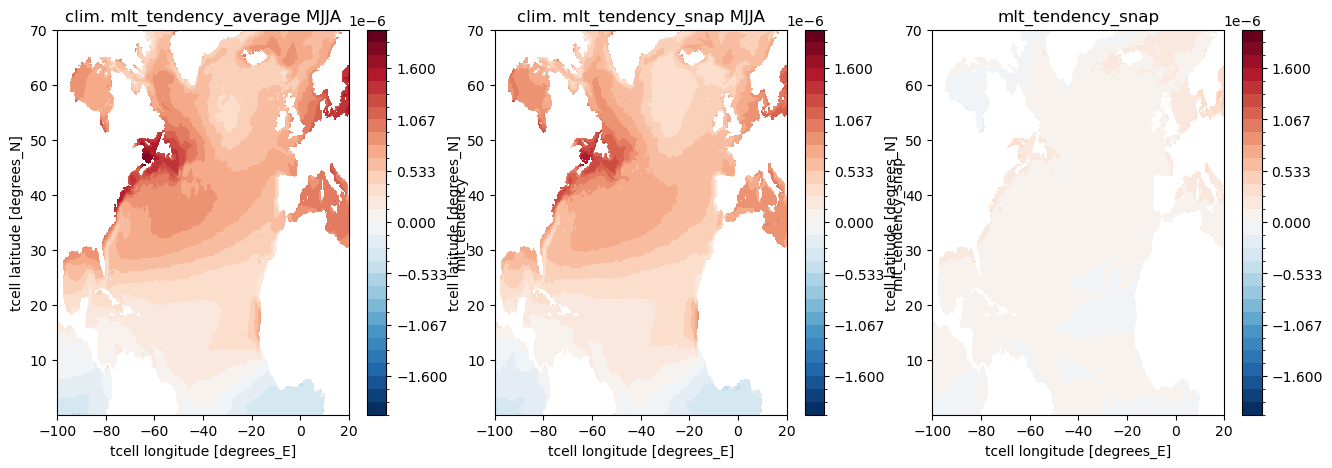

In [48]:
%%time
climatology['mlt_tendency_snap'] = climatology['mlt_tendency'].copy()
climatology['mlt_tendency_snap'] = full_time_budget['mlt_tendency_snap'].isel(time=slice(275,275+30*12)).groupby('time.month').mean('time')

plt.figure(figsize=(16,5));
panel_a = climatology['mlt_tendency'].isel(month=slice(4,8)).mean('month')
panel_b = climatology['mlt_tendency_snap'].isel(month=slice(4,8)).mean('month')
panel_c = panel_a - panel_b

ticks = np.linspace(-2e-6,2e-6,31)
plt.subplot(1,3,1); panel_a.plot(levels=ticks); plt.title('clim. mlt_tendency_average MJJA')
plt.subplot(1,3,2); panel_b.plot(levels=ticks); plt.title('clim. mlt_tendency_snap MJJA')
plt.subplot(1,3,3); panel_c.plot(levels=ticks); plt.title('mlt_tendency_snap')
# Wall time: 

In [11]:
# set all values to zero and then NAN for the mlt_tendency and entrainment variables for now
# in the next step, I then add in the data for these two fields
climatology['mlt_tendency'] = xr.zeros_like(climatology['mlt_tendency']).where(climatology['mlt_tendency'] != 0)
climatology['entrainment']  = xr.zeros_like(climatology['entrainment']).where(climatology['mlt_tendency'] != 0)

In [32]:
mlt_snap

<xarray.DataArray (time: 792, yt_ocean: 393, xt_ocean: 480)> Size: 598MB
dask.array<setitem, shape=(792, 393, 480), dtype=float32, chunksize=(1, 393, 480), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 4kB -99.88 -99.62 -99.38 ... 19.38 19.62 19.88
  * yt_ocean  (yt_ocean) float64 3kB 0.125 0.375 0.625 ... 69.78 69.88 69.99
  * time      (time) datetime64[ns] 6kB 1958-01-30 1958-02-27 ... 2023-12-30

In [ ]:
%%time
mlt_snap2 = mlt_snap
shape = mlt_snap2.shape

a = np.transpose(mlt_snap.isel(time=slice(1,None)).values - mlt_snap.isel(time=slice(0,-1)).values,(2, 0, 1))
a.shape

#mlt_snap2['mlt_tendency'] = mlt_snap2['mlt_tendency']/(mlt_snap2.average_DT / np.timedelta64(1, 's'))

In [ ]:
climatology['mlt_tendency'].data = (mlt_snap.isel(time=slice(1,None)).values - mlt_snap.isel(time=slice(0,-1)).values)

In [ ]:
%%time
climatology['mlt_tendency'] = (mlt_snap.isel(time=slice(1,None)) - mlt_snap.isel(time=slice(0,-1))).isel(time=slice(275,275+30*12)).groupby('time.month').mean('time')
climatology['mlt_tendency'] = climatology['mlt_tendency']/(climatology.average_DT / np.timedelta64(1, 's'))
climatology['mlt_tendency'].isel(month=slice(4,8)).mean('month').plot()
# Wall time: 

In [ ]:
%%time

mlt_snap2[1:-1,:,:] = (mlt_snap.isel(time=slice(1,None)) - mlt_snap.isel(time=slice(0,-1)))
climatology['mlt_tendency'].data = mlt_snap2.isel(time=slice(275,275+30*12)).groupby('time.month').mean('time').values
# Wall time: 15min 24s

In [32]:
mlt_snap2[20,:,:].plot()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x147406205c60>>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
# climatology['mlt_tendency'] = ((mlt_snap.isel(time=slice(275,275+30*12)).isel(time=slice(1,None))) - (mlt_snap.isel(time=slice(275,275+30*12)).isel(time=slice(0,-1)))).groupby('time.month').mean('time').values

%%time
climatology['mlt_tendency'].data = np.transpose((((mlt_snap.isel(time=slice(275,275+30*12)).isel(time=slice(1,None))) - (mlt_snap.isel(time=slice(275,275+30*12)).isel(time=slice(0,-1))))),(0,1,2))
                                    
                                    
               #                     .isel(time=slice(275-12,275+30*12+12))).groupby('time.month').mean('time')

climatology['mlt_tendency'] = climatology['mlt_tendency']/(climatology.average_DT / np.timedelta64(1, 's'))

climatology['mlt_tendency'].isel(month=slice(4,8)).mean('month').plot()



In [ ]:
budget['mlt_tendency'].data = np.transpose(mlt_month.isel(time=slice(0,None)).values - mlt_month.values,(2, 0, 1))
budget['mlt_tendency'] = budget['mlt_tendency']/(ds_budget.average_DT / np.timedelta64(1, 's'))

# Entrainment term by residual:
budget['entrainment'] = -(budget['temp_tendency'] - budget['mlt_tendency'])

In [39]:
climatology.average_DT.values

array([2678400000000000, 2439360000000000, 2678400000000000,
       2592000000000000, 2678400000000000, 2592000000000000,
       2678400000000000, 2678400000000000, 2592000000000000,
       2678400000000000, 2592000000000000, 2678400000000000],
      dtype='timedelta64[ns]')

In [25]:
np.transpose((mlt_snap/mld_snap).isel(time=slice(1,None)).values - (mlt_snap/mld_snap).isel(time=slice(0,-1)).values,(2,0,1))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 29.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 29.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(

KeyboardInterrupt



In [24]:
%%time
# mixed layer temperature tendency from snapshots:
full_time_budget['mlt_tendency'] = xr.zeros_like(full_time_budget['temp_tendency']).copy(deep=True)

#shape = ds_budget_in_mld.temp_tendency.shape
# full_time_budget['mlt_tendency'].data = np.transpose((mlt_snap/mld_snap).isel(time=slice(1,None)).values - (mlt_snap/mld_snap).isel(time=slice(0,-1)).values,(2,0,1))
full_time_budget['mlt_tendency'].data = np.transpose((mlt_snap/mld_snap).isel(time=slice(1,None)).values - (mlt_snap/mld_snap).isel(time=slice(0,-1)).values,(2,0,1))
# Wall time: 

ValueError: Dimensions {(2, 0, 1)} do not exist. Expected one or more of ('time', 'yt_ocean', 'xt_ocean')

In [ ]:
full_time_budget['mlt_tendency'] = ds_budget_in_mld['mlt_tendency']/(full_time_budget.average_DT / np.timedelta64(1, 's'))/rho0
# Units: degC * kg / m3 * m / m / sec / (kg/m3) = degC / sec

# Entrainment term by residual:
full_time_budget['entrainment'] = -(ds_budget_in_mld['temp_tendency'] - ds_budget_in_mld['mlt_tendency'])

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 29.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py

ValueError: replacement data must match the Variable's shape. replacement data has shape (480, 791, 393); Variable has shape (792, 393, 480)

In [16]:
full_time_budget.average_DT

<xarray.DataArray 'average_DT' (time: 792)> Size: 6kB
dask.array<concatenate, shape=(792,), dtype=timedelta64[ns], chunksize=(12,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2023-12-14T12:...
Attributes:
    long_name:  Length of average period

In [12]:
# with the following analysis, I lose a few data points at the beginning/end of the time period but that is okay because I extended my climatology period to 1980-2011 (32 years) and then
# cut off the two years again to have a clean 30-year climatology
full_time_budget['mlt_tendency'][1:,:,:]   = (mlt_snap.isel(time=slice(1,None)).values - mlt_snap.isel(time=slice(0,-1)).values)   # temp differencing (the top part)

a                 = ((full_time_budget.average_DT.isel(time=slice(1,None)) + full_time_budget.average_DT.isel(time=slice(0,-1))) / 2) / np.timedelta64(1, 's')     # time differencing (the bottom part)

# the second line (a) divides is \Delta t converted to number of seconds by dividing by the timedelta of a second
full_time_budget['mlt_tendency'][1:-1,:,:] = full_time_budget['mlt_tendency'][1:-1,:,:] / a # divide top by bottom part of fraction 

# do the entrainment term by residual:
full_time_budget['entrainment'] = -(full_time_budget['temp_tendency'] - full_time_budget['mlt_tendency'])

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 29.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 1.11 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


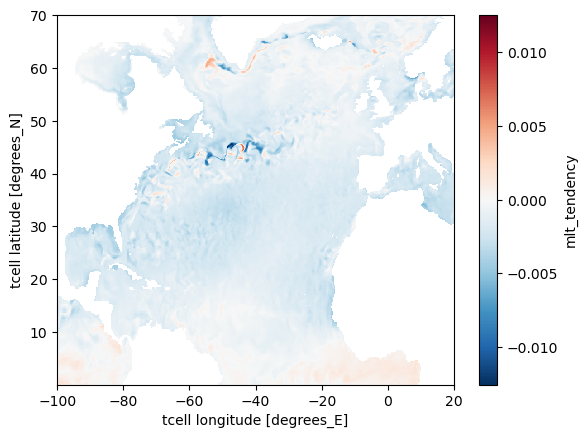

In [15]:
full_time_budget['mlt_tendency'].mean('time').plot()

In [ ]:
# remove the superfluous variables
#full_time_budget = full_time_budget.drop_vars(['ml_temp', 'average_DT'])

In [ ]:
full_time_budget.temp_tendency

In [ ]:
# mixed layer temperature tendency:
budget['mlt_tendency'] = budget['temp_tendency'].copy()
shape = budget.temp_tendency.shape
budget['mlt_tendency'].data = np.transpose(mlt_snap.isel(time=slice(1,None)).values - mlt_snap.isel(time=slice(0,-1)).values,(2, 0, 1))
budget['mlt_tendency'] = budget['mlt_tendency']/(ds_budget.average_DT / np.timedelta64(1, 's'))

In [9]:
a = np.linspace(0,len(full_time_budget.time)+1,len(full_time_budget.time)+1) # array from 0-781, the length of the xarray
for f,g in zip(a[0::12],a[12::12]): # loop through the years, in iterations of 12: [0, 12], [12, 24], [24, 36], ...
    f = int(f); g = int(g)
    year = str(full_time_budget.isel(time=slice(f,g)).time[0].values)[0:4] # select the name of the year from the xr.time information
    # skip iteration if file already exists
    if os.path.exists('/g/data/e14/mv7494/NASST_data/full_mixed_layer_heat_budget_year_'+year+'.nc'):
        print('year '+year+' already done')
    else:
        print('creating file for year '+year)
        # add attributes
        full_time_budget.attrs = {
                           'Project': 'North Atlantic Ocean Heat Wave 2023',
                           'Author': 'Maurice F. Huguenin', 
                           'Data set': 'ACCESS-OM2-025 IAF simulation (cycle6)',
                           'Unit': '°C/month, except for [average_DT] (ns) and [sst] (°C)',
                           'Climatology': '1981-2010 monthly climatology',
                           'Created': datetime.today().strftime('%Y-%m-%d'), 
                           'Mail': 'm.huguenin-virchaux@unsw.edu.au', 
                           'Funding': 'UNSW (Program code 1476), ARC ACEAS (ARC Grant No. SR200100008), ARC CLEX (ARC Grant No. CE170100023)'}
        if f == 0: # remove the first month of data because of the differencing I lose that month's data
            full_time_budget.isel(time=slice(f+1,   g)).to_netcdf('/g/data/e14/mv7494/NASST_data/full_mixed_layer_heat_budget_year_'+year+'.nc') # save as netcdf file
        if f == 780: # same for the very last data entry
            full_time_budget.isel(time=slice(f  , g-2)).to_netcdf('/g/data/e14/mv7494/NASST_data/full_mixed_layer_heat_budget_year_'+year+'.nc') # save as netcdf file
        else:
            full_time_budget.isel(time=slice(f  ,   g)).to_netcdf('/g/data/e14/mv7494/NASST_data/full_mixed_layer_heat_budget_year_'+year+'.nc') # save as netcdf file
    if f % 5 == 0: print('----------------------------') # print a line every 5 output files
# Wall time: 46.4 s

year 1958 already done
----------------------------
year 1959 already done
year 1960 already done
year 1961 already done
year 1962 already done
year 1963 already done
----------------------------
year 1964 already done
year 1965 already done
year 1966 already done
year 1967 already done
year 1968 already done
----------------------------
year 1969 already done
year 1970 already done
year 1971 already done
year 1972 already done
year 1973 already done
----------------------------
year 1974 already done
year 1975 already done
year 1976 already done
year 1977 already done
year 1978 already done
----------------------------
year 1979 already done
year 1980 already done
year 1981 already done
year 1982 already done
year 1983 already done
----------------------------
year 1984 already done
year 1985 already done
year 1986 already done
year 1987 already done
year 1988 already done
----------------------------
year 1989 already done
year 1990 already done
year 1991 already done
year 1992 alrea